In [1]:
# Import required libraries
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# Data paths
path_to_NDVI_data = "/ptmp/mp002/ellis/veg_forecast/NDVI_VNP43C4_v002_GHA.nc"
path_to_CHIRPS_data = "//ptmp/mp002/ellis/veg_forecast/CHIRPS_v002_weekly_sum_VNP43C4_GHA.nc"
path_elevation = "/ptmp/mp002/ellis/veg_forecast/srtm_5km_projection.tif"
path_landcover = "/ptmp/mp002/ellis/veg_forecast/COPERNICUS_Landcover_2019_GHA_reprojected.tif"


# Define bounding box coordinates
BBOX = {'min_lat': -5.5820, 'max_lat': 15.98, 'min_lon': 21.3070, 'max_lon': 53.14}


NDVI variable: NDVI_VNP43C4_GHA
CHIRPS variable: CHIRPS_mm_per_week


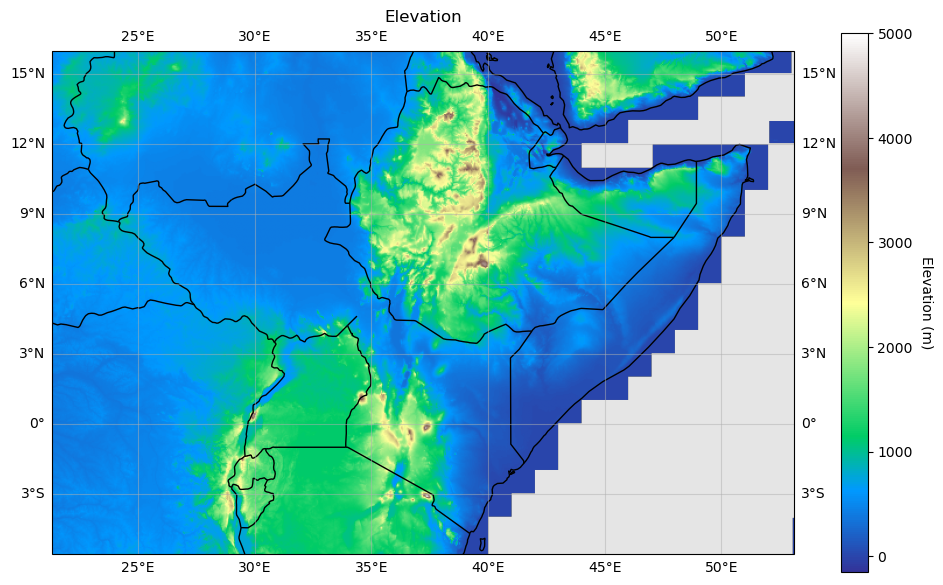

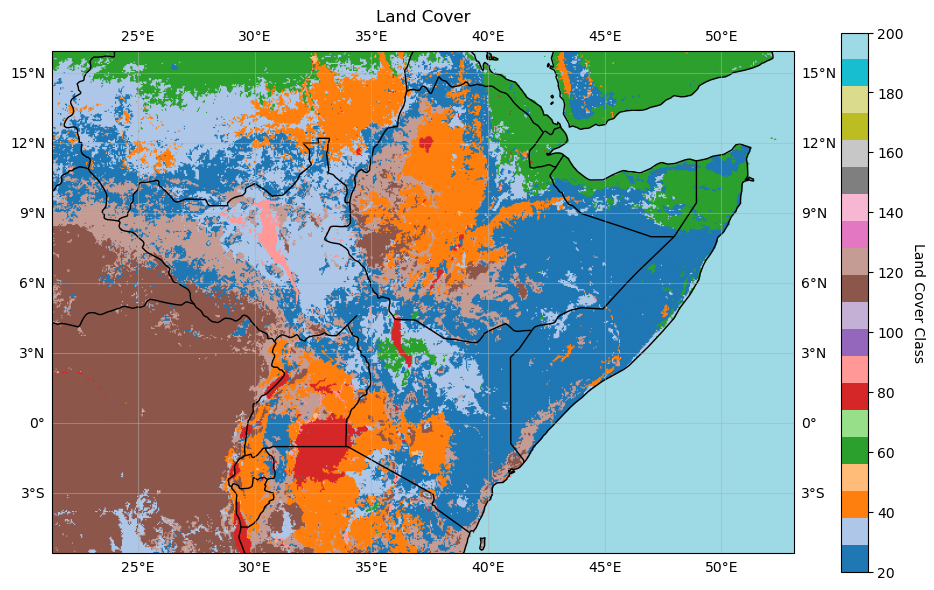

In [5]:


def load_and_subset_netcdf(file_path, bbox):
    """Load NetCDF data and apply spatial subset (assuming descending lat)"""
    ds = xr.open_dataset(file_path)
    # For descending latitudes, reverse the slice
    return ds.sel(lat=slice(bbox['max_lat'], bbox['min_lat']), 
                  lon=slice(bbox['min_lon'], bbox['max_lon']))

def load_and_subset_raster(raster_path, bbox):
    """Load raster and subset to bounding box"""
    with rasterio.open(raster_path) as src:
        window = rasterio.windows.from_bounds(
            bbox['min_lon'], bbox['min_lat'], bbox['max_lon'], bbox['max_lat'], src.transform)
        data = src.read(1, window=window)
        transform = rasterio.windows.transform(window, src.transform)
        
        height, width = data.shape
        lons_1d = [rasterio.transform.xy(transform, 0, col)[0] for col in range(width)]
        lats_1d = [rasterio.transform.xy(transform, row, 0)[1] for row in range(height)]
        lons_2d, lats_2d = np.meshgrid(lons_1d, lats_1d)
        
        return data, lons_2d, lats_2d

def create_landcover_mask(landcover_data, valid_classes=[20, 30]):
    """Create mask for specific land cover classes"""
    return np.isin(landcover_data, valid_classes)

def regrid_mask(mask, mask_lons, mask_lats, target_ds):
    """Regrid land cover mask to match dataset resolution using nearest neighbor"""
    target_lons, target_lats = np.meshgrid(target_ds.lon.values, target_ds.lat.values)
    
    mask_points = np.column_stack([mask_lons.ravel(), mask_lats.ravel()])
    target_points = np.column_stack([target_lons.ravel(), target_lats.ravel()])
    
    tree = cKDTree(mask_points)
    _, indices = tree.query(target_points)
    
    return mask.ravel()[indices].reshape(target_lons.shape)

def plot_data(data, title="", bbox=BBOX, cmap='viridis', vmin=None, vmax=None, 
              apply_mask=None, colorbar_label=""):
    """Generic plotting function for both NetCDF and raster data"""
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Apply mask if provided
    if apply_mask is not None:
        if hasattr(data, 'where'):  # xarray
            data = data.where(apply_mask)
        else:  # numpy array
            data = np.where(apply_mask, data, np.nan)
    
    # Plot based on data type
    if hasattr(data, 'plot'):  # xarray
        im = data.plot(ax=ax, transform=ccrs.PlateCarree(), 
                       cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
    else:  # numpy array (raster)
        im = ax.imshow(data, extent=[bbox['min_lon'], bbox['max_lon'], 
                                   bbox['min_lat'], bbox['max_lat']], 
                      transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.OCEAN, color='grey', alpha=0.2) 
    ax.gridlines(draw_labels=True, alpha=0.5)
    ax.set_xlim([bbox['min_lon'], bbox['max_lon']])
    ax.set_ylim([bbox['min_lat'], bbox['max_lat']])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.7)
    if colorbar_label:
        cbar.set_label(colorbar_label, rotation=270, labelpad=15)
    
    plt.title(title)
    plt.tight_layout()
    return fig

def get_time_averaged_data(dataset, var_name, time_selection, aggregation='mean'):
    """
    Get time-averaged data with flexible selection
    
    Parameters:
    - dataset: xarray dataset
    - var_name: variable name
    - time_selection: int (year), string (year, year-month, or year-month-day)
    - aggregation: 'mean' or 'max' or 'sum'
    """
    # Convert integer year to string
    if isinstance(time_selection, int):
        time_selection = str(time_selection)
    
    # Handle different time formats
    if isinstance(time_selection, str):
        if len(time_selection) == 4:  # Year: "2020"
            selected_data = dataset[var_name].sel(time=time_selection)
        elif len(time_selection) == 7:  # Year-Month: "2020-06"
            selected_data = dataset[var_name].sel(time=time_selection)
        elif len(time_selection) == 10:  # Year-Month-Day: "2020-06-24"
            return dataset[var_name].sel(time=time_selection, method='nearest')
        else:
            return dataset[var_name].sel(time=time_selection, method='nearest')
    else:
        return dataset[var_name].sel(time=time_selection, method='nearest')
    
    # Apply aggregation
    if aggregation == 'mean':
        return selected_data.mean(dim='time')
    elif aggregation == 'max':
        return selected_data.max(dim='time')
    elif aggregation == 'sum':
        return selected_data.sum(dim='time')
    else:
        return selected_data.mean(dim='time')

def get_time_title(time_selection):
    """Generate appropriate title based on time selection"""
    if isinstance(time_selection, int):
        return f"Annual {time_selection}"
    elif isinstance(time_selection, str):
        if len(time_selection) == 4:  # Year
            return f"Annual {time_selection}"
        elif len(time_selection) == 7:  # Year-Month
            try:
                date_obj = pd.to_datetime(time_selection)
                return f"{date_obj.strftime('%B %Y')}"
            except:
                return f"Monthly {time_selection}"
        elif len(time_selection) == 10:  # Year-Month-Day
            try:
                date_obj = pd.to_datetime(time_selection)
                return f"{date_obj.strftime('%B %d, %Y')}"
            except:
                return f"Daily {time_selection}"
        else:
            return str(time_selection)
    else:
        return str(time_selection)


# Main analysis
# Load data
ndvi_ds = load_and_subset_netcdf(path_to_NDVI_data, BBOX)
chirps_ds = load_and_subset_netcdf(path_to_CHIRPS_data, BBOX)

elevation_data, elevation_lons, elevation_lats = load_and_subset_raster(path_elevation, BBOX)
landcover_data, landcover_lons, landcover_lats = load_and_subset_raster(path_landcover, BBOX)

# Create and regrid land cover mask
landcover_mask = create_landcover_mask(landcover_data)
ndvi_landcover_mask = regrid_mask(landcover_mask, landcover_lons, landcover_lats, ndvi_ds)

# Get variable names
ndvi_var = list(ndvi_ds.data_vars)[0]
chirps_var = list(chirps_ds.data_vars)[0]

print(f"NDVI variable: {ndvi_var}")
print(f"CHIRPS variable: {chirps_var}")

# Plot raster data
plot_data(elevation_data, "Elevation", cmap='terrain', colorbar_label='Elevation (m)')
plt.show()

plot_data(landcover_data, "Land Cover", cmap='tab20', colorbar_label='Land Cover Class')
plt.show()




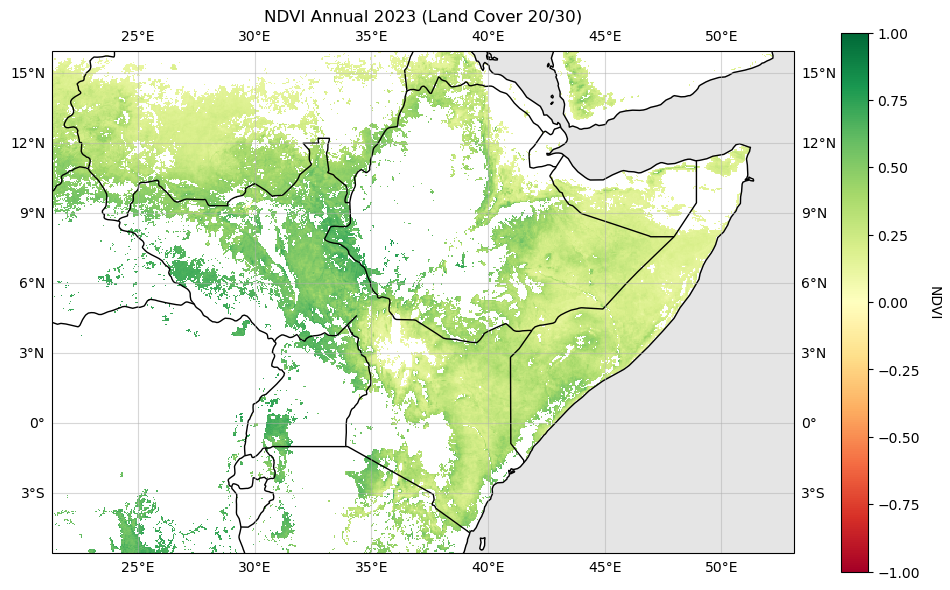

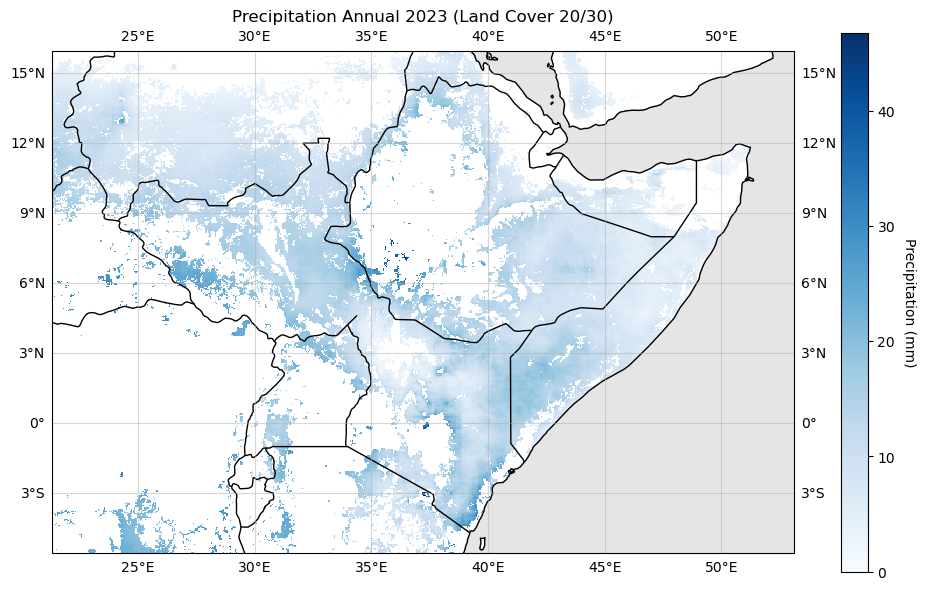

In [6]:
# FLEXIBLE TIME SELECTION - Change this line to analyze different periods
time = "2023"  # Examples: 2020, "2020", "2020-06", "2020-06-24"

# NDVI plots 
ndvi_time = get_time_averaged_data(ndvi_ds, ndvi_var, time, aggregation='mean')
time_title = get_time_title(time)

plot_data(ndvi_time, f"NDVI {time_title} (Land Cover 20/30)", 
            cmap='RdYlGn', vmin=-1, vmax=1, apply_mask=ndvi_landcover_mask, 
            colorbar_label='NDVI')
plt.show()

# Precipitation plots
chirps_time = get_time_averaged_data(chirps_ds, chirps_var, time, aggregation='mean')

plot_data(chirps_time, f"Precipitation {time_title} (Land Cover 20/30)", 
            cmap='Blues', vmin=0,vmax=None, apply_mask=ndvi_landcover_mask, 
            colorbar_label='Precipitation (mm)')
plt.show()

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import os

def create_annual_animation(ndvi_ds, chirps_ds, ndvi_var, chirps_var, 
                           ndvi_landcover_mask, start_year, end_year, 
                           output_dir="animations", bbox=None):
    """
    Create animations showing annual changes in NDVI and precipitation
    
    Parameters:
    - ndvi_ds, chirps_ds: datasets
    - ndvi_var, chirps_var: variable names
    - ndvi_landcover_mask: land cover mask
    - start_year, end_year: year range (inclusive)
    - output_dir: directory to save animations
    - bbox: bounding box dictionary with keys: min_lon, max_lon, min_lat, max_lat
    """
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Use global BBOX if bbox not provided
    if bbox is None:
        bbox = BBOX
    
    years = list(range(start_year, end_year + 1))
    
    # Prepare data for all years
    ndvi_data = []
    precip_data = []
    valid_years = []
    
    for year in years:
        try:
            # Get annual averages
            ndvi_annual = get_time_averaged_data(ndvi_ds, ndvi_var, year, aggregation='mean')
            precip_annual = get_time_averaged_data(chirps_ds, chirps_var, year, aggregation='sum')
            
            # Apply mask
            ndvi_masked = ndvi_annual.where(ndvi_landcover_mask)
            precip_masked = precip_annual.where(ndvi_landcover_mask)
            
            ndvi_data.append(ndvi_masked)
            precip_data.append(precip_masked)
            valid_years.append(year)
            
        except Exception as e:
            print(f"Warning: Could not load data for {year}: {e}")
            continue
    
    if not ndvi_data:
        print("No valid data found for animation")
        return
    
    # Set FIXED color scales - NDVI always -1 to 1
    ndvi_min = -1.0
    ndvi_max = 1.0
    
    precip_min = 0
    precip_max = max([data.max().values for data in precip_data if not np.isnan(data.max().values)])
    
    # Create explicit normalization objects
    ndvi_norm = Normalize(vmin=ndvi_min, vmax=ndvi_max)
    precip_norm = Normalize(vmin=precip_min, vmax=precip_max)
    
    # Create NDVI animation
    def create_ndvi_animation():
        fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Initialize with first frame to set up the plot structure
        first_data = ndvi_data[0]
        im = ax.pcolormesh(first_data.lon, first_data.lat, first_data.values, 
                          transform=ccrs.PlateCarree(), 
                          cmap='RdYlGn', 
                          shading='auto', 
                          norm=ndvi_norm)  # Use explicit normalization
        
        # Add map features
        ax.add_feature(cfeature.COASTLINE, alpha=0.7)
        ax.add_feature(cfeature.BORDERS, alpha=0.7)
        ax.add_feature(cfeature.OCEAN, color='grey', alpha=0.2) 
        ax.gridlines(draw_labels=True, alpha=0.5)
        ax.set_xlim([bbox['min_lon'], bbox['max_lon']])
        ax.set_ylim([bbox['min_lat'], bbox['max_lat']])
        ax.set_title(f'NDVI Annual Average - {valid_years[0]}', fontsize=16, pad=20)
        
        # Create colorbar after initial plot with explicit normalization
        cbar = plt.colorbar(im, ax=ax, shrink=0.7, aspect=30)
        cbar.set_label('NDVI', rotation=270, labelpad=20, fontsize=12)
        
        def animate_ndvi(frame):
            # Clear only the data, not the entire axes
            # Flatten the array and ensure it respects the normalization
            data_flat = ndvi_data[frame].values.ravel()
            im.set_array(data_flat)
            # Ensure normalization is maintained
            im.set_clim(vmin=ndvi_min, vmax=ndvi_max)
            ax.set_title(f'NDVI Annual Average - {valid_years[frame]}', fontsize=16, pad=20)
            return [im]
        
        # Create animation
        anim = FuncAnimation(fig, animate_ndvi, frames=len(valid_years), 
                           interval=800, blit=False, repeat=True)
        
        return anim
    
    # Create Precipitation animation
    def create_precip_animation():
        fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Initialize with first frame to set up the plot structure
        first_data = precip_data[0]
        im = ax.pcolormesh(first_data.lon, first_data.lat, first_data.values, 
                          transform=ccrs.PlateCarree(), 
                          cmap='Blues', 
                          shading='auto', 
                          norm=precip_norm)  # Use explicit normalization
        
        # Add map features
        ax.add_feature(cfeature.COASTLINE, alpha=0.7)
        ax.add_feature(cfeature.BORDERS, alpha=0.7)
        ax.add_feature(cfeature.OCEAN, color='grey', alpha=0.2) 
        ax.gridlines(draw_labels=True, alpha=0.5)
        ax.set_xlim([bbox['min_lon'], bbox['max_lon']])
        ax.set_ylim([bbox['min_lat'], bbox['max_lat']])
        ax.set_title(f'Precipitation Annual Total - {valid_years[0]}', fontsize=16, pad=20)
        
        # Create colorbar after initial plot with explicit normalization
        cbar = plt.colorbar(im, ax=ax, shrink=0.7, aspect=30)
        cbar.set_label('Precipitation (mm)', rotation=270, labelpad=20, fontsize=12)
        
        def animate_precip(frame):
            # Update only the data, not the entire plot
            data_flat = precip_data[frame].values.ravel()
            im.set_array(data_flat)
            # Ensure normalization is maintained
            im.set_clim(vmin=precip_min, vmax=precip_max)
            ax.set_title(f'Precipitation Annual Total - {valid_years[frame]}', fontsize=16, pad=20)
            return [im]
        
        # Create animation
        anim = FuncAnimation(fig, animate_precip, frames=len(valid_years), 
                           interval=800, blit=False, repeat=True)
        
        return anim
    
    # Create and save animations
    print("Creating NDVI animation...")
    ndvi_anim = create_ndvi_animation()
    
    print("Creating Precipitation animation...")
    precip_anim = create_precip_animation()
    
    # Save as GIFs only
    print("Saving NDVI GIF...")
    ndvi_anim.save(f'{output_dir}/ndvi_annual_{start_year}-{end_year}.gif', 
                   writer=PillowWriter(fps=1.2))
    
    print("Saving Precipitation GIF...")
    precip_anim.save(f'{output_dir}/precipitation_annual_{start_year}-{end_year}.gif', 
                     writer=PillowWriter(fps=1.2))
    
    plt.close('all')
    print(f"Animations saved to {output_dir}/ directory")


def create_monthly_animation(ndvi_ds, chirps_ds, ndvi_var, chirps_var, 
                            ndvi_landcover_mask, start_year, end_year, 
                            output_dir="animations", bbox=None, selected_months=None):
    """
    Create animations showing monthly changes over multiple years
    
    Parameters:
    - ndvi_ds, chirps_ds: datasets
    - ndvi_var, chirps_var: variable names
    - ndvi_landcover_mask: land cover mask
    - start_year, end_year: year range (inclusive)
    - output_dir: directory to save animations
    - bbox: bounding box dictionary
    - selected_months: list of months to include (1-12), if None uses all months
    """
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Use global BBOX if bbox not provided
    if bbox is None:
        bbox = BBOX
    
    # Use all months if none selected
    if selected_months is None:
        selected_months = list(range(1, 13))
    
    # Generate selected year-month combinations
    time_points = []
    for year in range(start_year, end_year + 1):
        for month in selected_months:
            time_points.append(f"{year}-{month:02d}")
    
    # Prepare data
    print(f"Preparing monthly data for {len(time_points)} time points...")
    ndvi_data = []
    precip_data = []
    valid_times = []
    
    for time_str in time_points:
        try:
            ndvi_monthly = get_time_averaged_data(ndvi_ds, ndvi_var, time_str, aggregation='mean')
            precip_monthly = get_time_averaged_data(chirps_ds, chirps_var, time_str, aggregation='sum')
            
            ndvi_masked = ndvi_monthly.where(ndvi_landcover_mask)
            precip_masked = precip_monthly.where(ndvi_landcover_mask)
            
            ndvi_data.append(ndvi_masked)
            precip_data.append(precip_masked)
            valid_times.append(time_str)
            
        except Exception as e:
            print(f"Warning: Could not load data for {time_str}: {e}")
            continue
    
    if not ndvi_data:
        print("No valid monthly data found")
        return
    
    print(f"Creating monthly animations for {len(valid_times)} months")
    
    # Set FIXED color scales - NDVI always -1 to 1
    ndvi_min = -1.0
    ndvi_max = 1.0
    
    precip_min = 0
    precip_max = max([data.max().values for data in precip_data if not np.isnan(data.max().values)])
    
    # Create explicit normalization objects
    ndvi_norm = Normalize(vmin=ndvi_min, vmax=ndvi_max)
    precip_norm = Normalize(vmin=precip_min, vmax=precip_max)
    
    def create_monthly_ndvi_animation():
        fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Initialize with first frame
        first_data = ndvi_data[0]
        date_obj = pd.to_datetime(valid_times[0])
        title_date = date_obj.strftime('%B %Y')
        
        im = ax.pcolormesh(first_data.lon, first_data.lat, first_data.values, 
                          transform=ccrs.PlateCarree(), 
                          cmap='RdYlGn', 
                          shading='auto', 
                          norm=ndvi_norm)  # Use explicit normalization
        
        ax.add_feature(cfeature.COASTLINE, alpha=0.7)
        ax.add_feature(cfeature.BORDERS, alpha=0.7)
        ax.add_feature(cfeature.OCEAN, color='grey', alpha=0.2) 
        ax.gridlines(draw_labels=True, alpha=0.5)
        ax.set_xlim([bbox['min_lon'], bbox['max_lon']])
        ax.set_ylim([bbox['min_lat'], bbox['max_lat']])
        ax.set_title(f'NDVI Monthly Average - {title_date}', fontsize=16, pad=20)
        
        # Create colorbar with explicit normalization
        cbar = plt.colorbar(im, ax=ax, shrink=0.7, aspect=30)
        cbar.set_label('NDVI', rotation=270, labelpad=20, fontsize=12)
        
        def animate_monthly_ndvi(frame):
            # Update data and title
            time_str = valid_times[frame]
            date_obj = pd.to_datetime(time_str)
            title_date = date_obj.strftime('%B %Y')
            
            data_flat = ndvi_data[frame].values.ravel()
            im.set_array(data_flat)
            # Ensure normalization is maintained
            im.set_clim(vmin=ndvi_min, vmax=ndvi_max)
            ax.set_title(f'NDVI Monthly Average - {title_date}', fontsize=16, pad=20)
            
            return [im]
        
        anim = FuncAnimation(fig, animate_monthly_ndvi, frames=len(valid_times), 
                           interval=400, blit=False, repeat=True)
        
        return anim
    
    def create_monthly_precip_animation():
        fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Initialize with first frame
        first_data = precip_data[0]
        date_obj = pd.to_datetime(valid_times[0])
        title_date = date_obj.strftime('%B %Y')
        
        im = ax.pcolormesh(first_data.lon, first_data.lat, first_data.values, 
                          transform=ccrs.PlateCarree(), 
                          cmap='Blues', 
                          shading='auto', 
                          norm=precip_norm)  # Use explicit normalization
        
        ax.add_feature(cfeature.COASTLINE, alpha=0.7)
        ax.add_feature(cfeature.BORDERS, alpha=0.7)
        ax.add_feature(cfeature.OCEAN, color='grey', alpha=0.2) 
        ax.gridlines(draw_labels=True, alpha=0.5)
        ax.set_xlim([bbox['min_lon'], bbox['max_lon']])
        ax.set_ylim([bbox['min_lat'], bbox['max_lat']])
        ax.set_title(f'Precipitation Monthly Total - {title_date}', fontsize=16, pad=20)
        
        # Create colorbar with explicit normalization
        cbar = plt.colorbar(im, ax=ax, shrink=0.7, aspect=30)
        cbar.set_label('Precipitation (mm)', rotation=270, labelpad=20, fontsize=12)
        
        def animate_monthly_precip(frame):
            # Update data and title
            time_str = valid_times[frame]
            date_obj = pd.to_datetime(time_str)
            title_date = date_obj.strftime('%B %Y')
            
            data_flat = precip_data[frame].values.ravel()
            im.set_array(data_flat)
            # Ensure normalization is maintained
            im.set_clim(vmin=precip_min, vmax=precip_max)
            ax.set_title(f'Precipitation Monthly Total - {title_date}', fontsize=16, pad=20)
            
            return [im]
        
        anim = FuncAnimation(fig, animate_monthly_precip, frames=len(valid_times), 
                           interval=400, blit=False, repeat=True)
        
        return anim
    
    # Create and save monthly animations
    print("Creating monthly NDVI animation...")
    ndvi_monthly_anim = create_monthly_ndvi_animation()
    
    print("Creating monthly Precipitation animation...")
    precip_monthly_anim = create_monthly_precip_animation()
    
    # Determine filename suffix based on selected months
    if selected_months == [1, 6]:
        suffix = "biannual"
    elif selected_months == [1, 4, 7, 10]:
        suffix = "quarterly"
    elif len(selected_months) == 12:
        suffix = "monthly"
    else:
        suffix = f"months_{'_'.join(map(str, selected_months))}"
    
    # Save as GIFs only
    print(f"Saving {suffix} GIFs...")
    ndvi_monthly_anim.save(f'{output_dir}/ndvi_{suffix}_{start_year}-{end_year}.gif', 
                          writer=PillowWriter(fps=2.5))
    precip_monthly_anim.save(f'{output_dir}/precipitation_{suffix}_{start_year}-{end_year}.gif', 
                            writer=PillowWriter(fps=2.5))
    
    plt.close('all')
    print(f"{suffix.capitalize()} animations saved to {output_dir}/ directory")


# Usage Examples:

# Create annual animations (one frame per year)
print("Creating annual animations...")
create_annual_animation(ndvi_ds, chirps_ds, ndvi_var, chirps_var, 
                       ndvi_landcover_mask, start_year=2012, end_year=2024, 
                       output_dir="annual_animations")

# Bi-annual (January & June) - FAST for 2012-2024
print("\nCreating bi-annual animations...")
create_monthly_animation(ndvi_ds, chirps_ds, ndvi_var, chirps_var, 
                        ndvi_landcover_mask, start_year=2012, end_year=2024, 
                        output_dir="biannual_animations", 
                        selected_months=[1, 6])

# Quarterly (4 seasons)
print("\nCreating quarterly animations...")
create_monthly_animation(ndvi_ds, chirps_ds, ndvi_var, chirps_var, 
                        ndvi_landcover_mask, start_year=2012, end_year=2024, 
                        output_dir="quarterly_animations", 
                        selected_months=[1, 4, 7, 10])

print("\nAnimation creation complete!")
print("Check the output directories for animation files.")

Creating annual animations...
Creating NDVI animation...
Creating Precipitation animation...
Saving NDVI GIF...
Saving Precipitation GIF...
Animations saved to annual_animations/ directory

Creating bi-annual animations...
Preparing monthly data for 26 time points...
Creating monthly animations for 26 months
Creating monthly NDVI animation...
Creating monthly Precipitation animation...
Saving biannual GIFs...
Biannual animations saved to biannual_animations/ directory

Creating quarterly animations...
Preparing monthly data for 52 time points...
Creating monthly animations for 52 months
Creating monthly NDVI animation...
Creating monthly Precipitation animation...
Saving quarterly GIFs...
Quarterly animations saved to quarterly_animations/ directory

Animation creation complete!
Check the output directories for animation files.


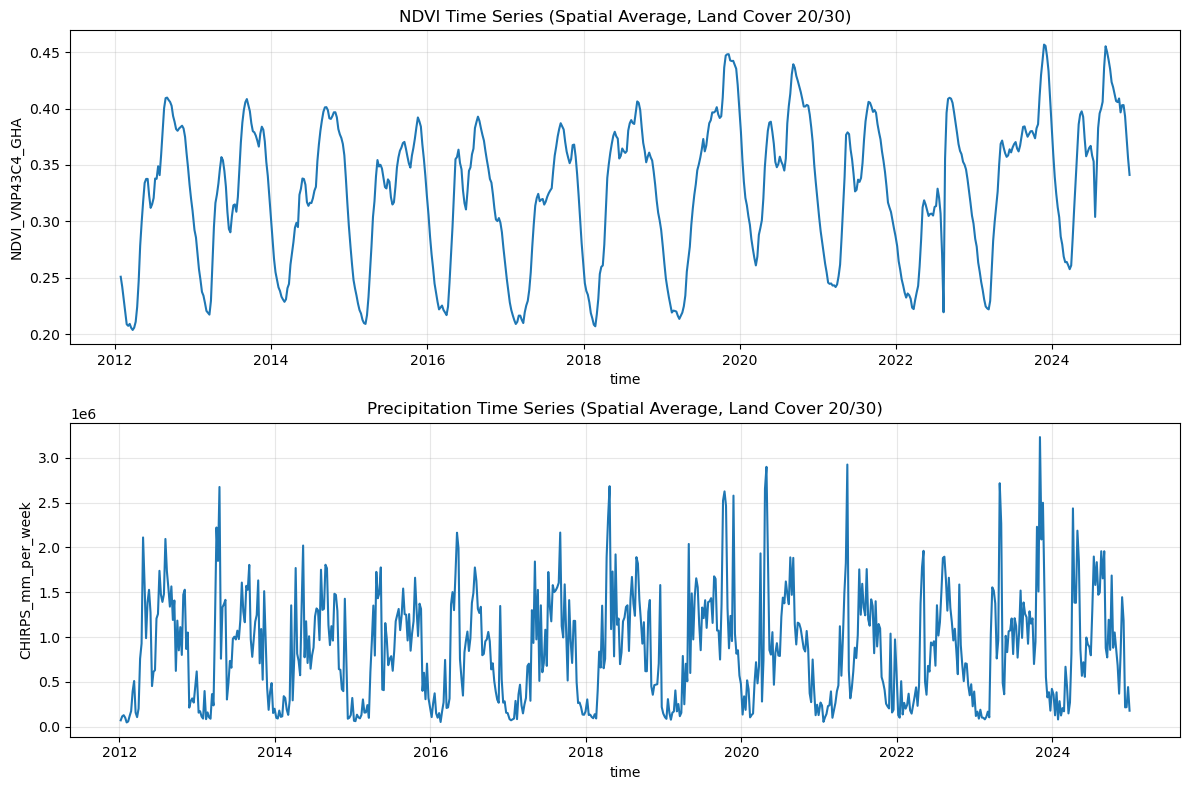

In [12]:

# Time series
ndvi_ts = ndvi_ds[ndvi_var].where(ndvi_landcover_mask).mean(dim=['lat', 'lon'])
chirps_ts = chirps_ds[chirps_var].where(ndvi_landcover_mask).sum(dim=['lat', 'lon'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ndvi_ts.plot(ax=ax1)
ax1.set_title('NDVI Time Series (Spatial Average, Land Cover 20/30)')
ax1.grid(True, alpha=0.3)

chirps_ts.plot(ax=ax2)
ax2.set_title('Precipitation Time Series (Spatial Average, Land Cover 20/30)')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


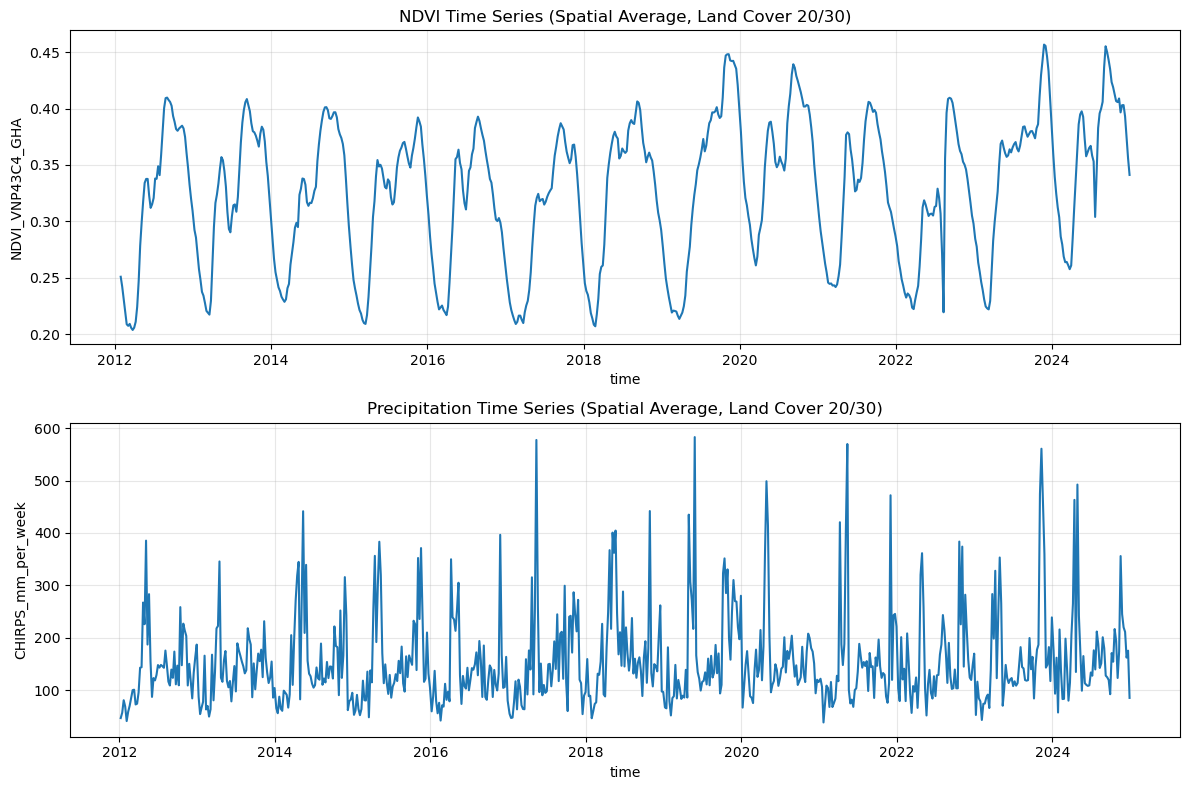

In [13]:

# Time series
ndvi_ts = ndvi_ds[ndvi_var].where(ndvi_landcover_mask).mean(dim=['lat', 'lon'])
chirps_ts = chirps_ds[chirps_var].where(ndvi_landcover_mask).max(dim=['lat', 'lon'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ndvi_ts.plot(ax=ax1)
ax1.set_title('NDVI Time Series (Spatial Average, Land Cover 20/30)')
ax1.grid(True, alpha=0.3)

chirps_ts.plot(ax=ax2)
ax2.set_title('Precipitation Time Series (Spatial Average, Land Cover 20/30)')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


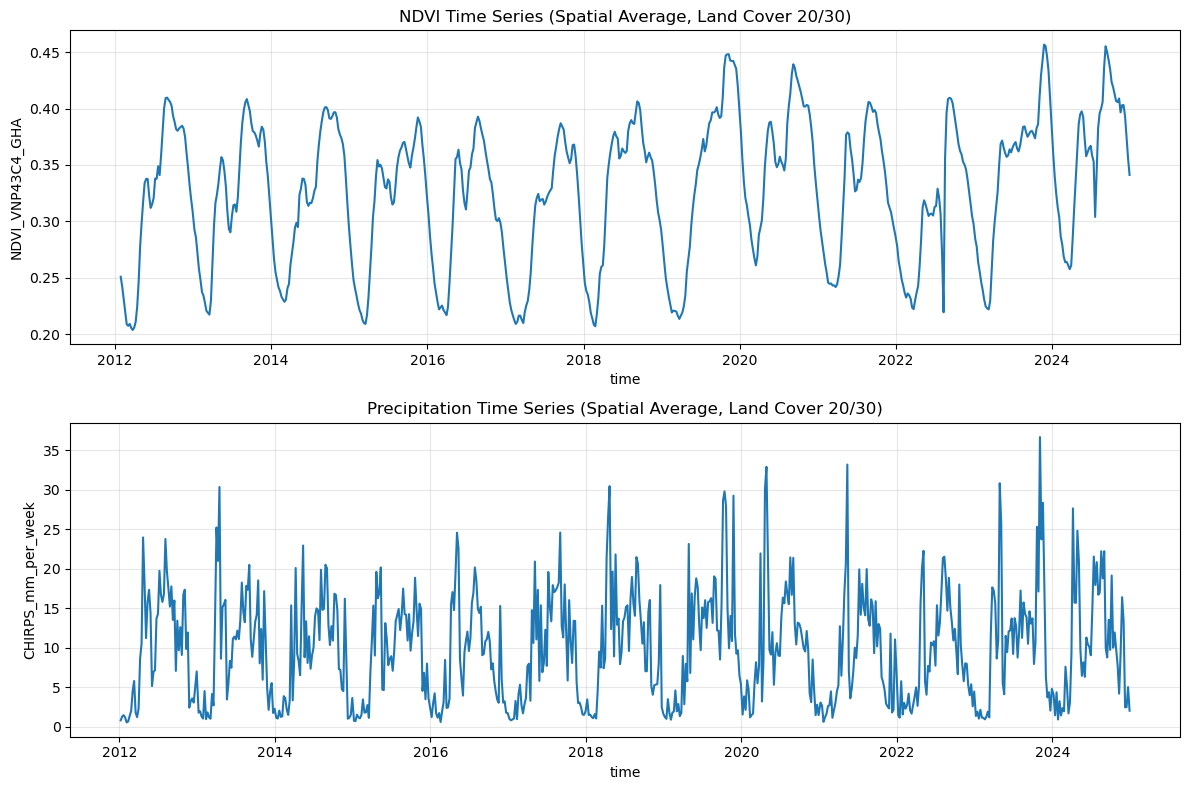

In [14]:

# Time series
ndvi_ts = ndvi_ds[ndvi_var].where(ndvi_landcover_mask).mean(dim=['lat', 'lon'])
chirps_ts = chirps_ds[chirps_var].where(ndvi_landcover_mask).mean(dim=['lat', 'lon'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ndvi_ts.plot(ax=ax1)
ax1.set_title('NDVI Time Series (Spatial Average, Land Cover 20/30)')
ax1.grid(True, alpha=0.3)

chirps_ts.plot(ax=ax2)
ax2.set_title('Precipitation Time Series (Spatial Average, Land Cover 20/30)')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
